# Transfer Learning in PyTorch

In this, the patterns or weights which another model has been learned from another problem will be used to improve our model

In [19]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Download the code for experimentation

In [1]:
import requests
import zipfile
from pathlib import Path

# Function to download a zip file from a URL
def download_zip(url, save_path):
    """This downloads zip files from the given URL,
    unzip them and saves it to the specified path.
    """
    if not save_path.is_file():  # Only download if the file doesn't already exist
        print(f"Downloading data from {url}...")
        response = requests.get(url)
        with open(save_path, "wb") as f:
            f.write(response.content)
        print(f"Downloaded and saved at {save_path}.")
    else:
        print(f"{save_path} already exists. Skipping download.")

# Function to unzip a file to a specified directory
def unzip_file(zip_path, extract_to):
    """Unzips a zip file to the specified directory."""
    if not any(extract_to.iterdir()):  # Check if the directory is empty
        print(f"Unzipping {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Unzipped to {extract_to}.")
    else:
        print(f"{extract_to} is not empty. Skipping unzip.")

# Set up paths for the data folder, train data, and test data
data_path = Path("data/")
train_image_path = data_path / "train_data"
test_image_path = data_path / "test_data"

# Paths to save downloaded zip files
train_zip_path = data_path / "train_data.zip"
test_zip_path = data_path / "test_data.zip"

# Create directories if they don't exist
train_image_path.mkdir(parents=True, exist_ok=True)
test_image_path.mkdir(parents=True, exist_ok=True)

# URLs for train and test zip files
train_url = "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/master/experimentation_data/train_data.zip"
test_url = "https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/master/experimentation_data/test_data.zip"

# Download train and test data using the function
download_zip(train_url, train_zip_path)
download_zip(test_url, test_zip_path)

# Unzip the downloaded files using the function
unzip_file(train_zip_path, train_image_path)
unzip_file(test_zip_path, test_image_path)

# Delete the zip files using Python instead of shell commands
if train_zip_path.is_file():
    train_zip_path.unlink()
if test_zip_path.is_file():
    test_zip_path.unlink()



Downloaded and saved at data/train_data.zip.
Downloaded and saved at data/test_data.zip.
Unzipping data/train_data.zip to data/train_data...
Unzipped to data/train_data.
Unzipping data/test_data.zip to data/test_data...
Unzipped to data/test_data.


In [20]:
train_dir = train_image_path / "data" / "images"
test_dir = test_image_path / "data" / "images"

## 2B. Import modules


In [21]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

In [22]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Installing torchinfo....")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from Part_3_pet_modules import data_setup, engine
except:
  # Get the going_modular scripts
  print("[INFO] Not already installed, but downloading them from GitHub.")
  !git clone https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision.git
  !mv Project-Oxford_IIIT_Pet_TorchVision/Part_3_pet_modules .
  !rm -rf Project-Oxford_IIIT_Pet_TorchVision
  from Part_3_pet_modules import data_setup, engine

## 2. Create Datasets and DataLoader

In this, we will auto-creation for creating a transform for torchvision.models

Manual creation can be used and customized based on what we want

The pre-trained model to first use is:
**RegNet_Y_400MF_Weights.IMAGENET1K_V2**

In [23]:
# get the default (best available) of pre-trained model weights
weights = torchvision.models.RegNet_Y_400MF_Weights.IMAGENET1K_V2.DEFAULT
weights

RegNet_Y_400MF_Weights.IMAGENET1K_V2

In [24]:
# Tranform using auto transforms
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
# Create dataloaders using auto transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f8208ac4d60>,
 ['boxer', 'pug', 'sphynx'])

## 3. Setting up a pre-trained model

In [26]:
model = torchvision.models.regnet_y_400mf(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_400mf-e6988f5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-e6988f5f.pth
100%|██████████| 16.8M/16.8M [00:00<00:00, 25.8MB/s]


In [40]:
model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [61]:
model.shape

AttributeError: 'RegNet' object has no attribute 'shape'

In [27]:
# Summary of the pre-trained model using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 1000]           --                   True
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 440, 7, 7]      --                   True
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 48, 56,

** This has parameters of 4,344,144 compared to TinyVG we previously developed with 8083 parameters.



### 3.1 Freezing the base model and modify the output for our needs

In [56]:
# Freeze all parameters in the stem and trunk_output (the feature extractor part of RegNet)
for param in model.stem.parameters():
    param.requires_grad = False

for param in model.trunk_output.parameters():
    param.requires_grad = False


In [57]:
# Summary of the pre-trained model using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 1000]           1,323                Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 440, 7, 7]      --                   False
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 

## 3.2 Update the classifier (output) layer

Note: Name of the final layer is used in updating output features.

In ResNet, final layer is named "fc"

In [66]:
# Access the input features of the last fully connected layer (ResNet's 'fc' layer)
in_features = model.fc.in_features
in_features

440

In [71]:
# Set the manual seeds
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the output layer, which is names as "fc" and seed it to the target device
# Note fc is used in model.fc because fc is the name of the output layer. Always update accordingly
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), # 20% of connections between neural network layers will be removed at random each pass
    torch.nn.Linear(in_features=in_features,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [72]:
# Summary of the pre-trained model using torchinfo
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 224, 224]    [32, 3]              1,323                Partial
├─SimpleStemIN (stem)                                        [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    └─Conv2d (0)                                            [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNorm2d (1)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    └─ReLU (2)                                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 112, 112]   [32, 440, 7, 7]      --                   False
│    └─AnyStage (block1)                                     [32, 32, 112, 112]   [32, 

## 4. Train Model

In [74]:
# Set loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
# Set the random seeds
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer
end_time = timer()

# Print training model
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1291 | train_acc: 0.3359 | test_loss: 0.9517 | test_acc: 0.5848
Epoch: 2 | train_loss: 0.8573 | train_acc: 0.6992 | test_loss: 0.7083 | test_acc: 0.8996
Epoch: 3 | train_loss: 0.6647 | train_acc: 0.8359 | test_loss: 0.5694 | test_acc: 0.9152
Epoch: 4 | train_loss: 0.4875 | train_acc: 0.9102 | test_loss: 0.4730 | test_acc: 0.9353
Epoch: 5 | train_loss: 0.4232 | train_acc: 0.8945 | test_loss: 0.4059 | test_acc: 0.9353
[INFO] Total training time: 110.266 seconds


**!!! Great improvement with transfer learning with test_acc: 0.9353 and train_acc: 0.8945**

## 5. Evaluate model

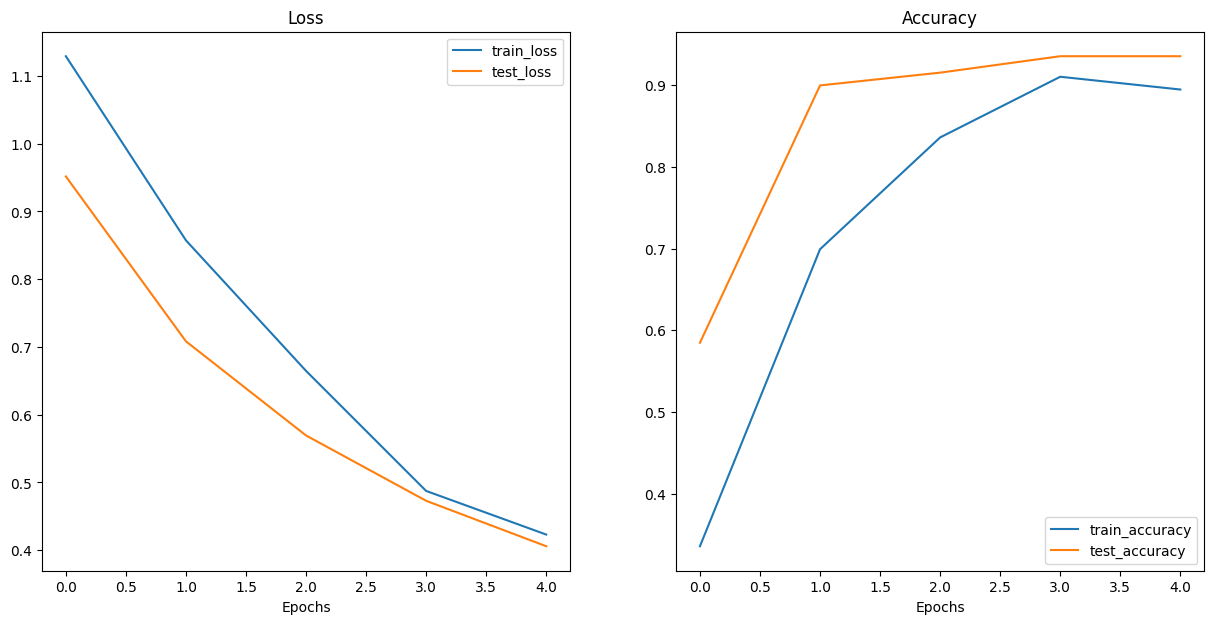

In [80]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://github.com/glorious0119/Project-Oxford_IIIT_Pet_TorchVision/raw/refs/heads/master/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6.Make predictions on test set images

Images that were not used in training



In [81]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

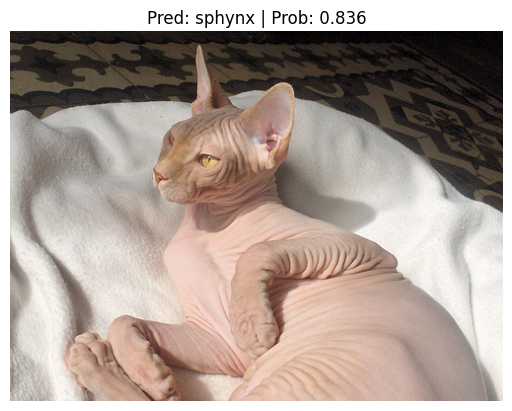

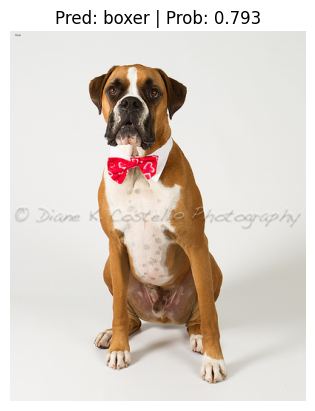

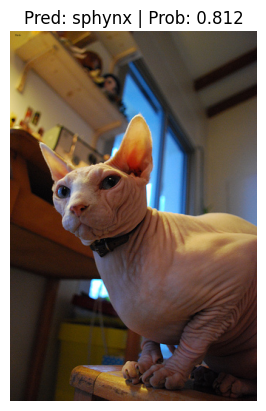

In [88]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

The prediction is far better

### 6.1 Predict on custom image randomly downloaded from internet

The image will either be a boxer, sphynx or pug since those are classes we used in training

Downloaded data/pet_image.


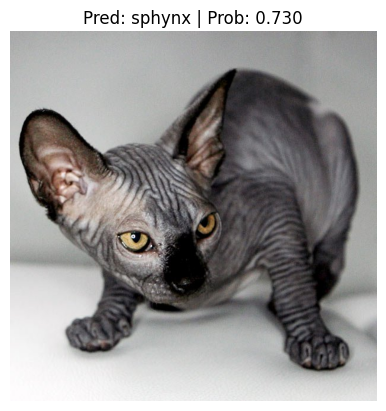

In [103]:
import requests
from pathlib import Path

def download_image(image_url: str, save_path: Path):
    """Download an image from a URL if it doesn't already exist.

    Args:
        image_url (str): URL of the image to download.
        save_path (Path): Local path where the image will be saved.

    Returns:
        bool: True if the image was downloaded, False if it already existed.
    """
    if not save_path.is_file():
        try:
            print(f"Downloading {save_path}...")
            response = requests.get(image_url, timeout=10)  # Added timeout for safety
            response.raise_for_status()  # Raise an error for bad responses (4xx or 5xx)
            with open(save_path, "wb") as f:
                f.write(response.content)
            print(f"Downloaded {save_path}.")
            return True
        except requests.exceptions.RequestException as e:
            print(f"[ERROR] Failed to download {save_path}: {e}")
            return False
    else:
        print(f"{save_path} already exists, skipping download.")
        return False

# Setup custom image path
custom_image_path = Path(data_path) / "pet_image"

# URL of the image to download
image_url = "https://inspirationseek.com/wp-content/uploads/2014/08/Cute-Sphynx-Cat-Photos.jpg"  # sphynx
# image_url = "https://animalsbreeds.com/wp-content/uploads/2015/01/Boxer-3.jpg"   # boxer
# image_url = "https://luvmydogs.com/wp-content/uploads/2014/08/pug-smile-6460394.jpg"  # pug

# Download the custom image
downloaded = download_image(image_url=image_url, save_path=custom_image_path)

# Predict on custom image if downloaded successfully
if downloaded or custom_image_path.is_file():
    pred_and_plot_image(model=model,
                        image_path=custom_image_path,
                        class_names=class_names)



In [102]:
# remove before testing another custom image
!rm -rf ./data/pet_image